In [8]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parte I: Implementacion de "Image Sharpness Measure for Blurred Images in Frequency Domain"

In [9]:
# Utility functions

def modify_video(capture, modifier):
    """
    Dado un modifier lo aplica a todos los frames de la captura.
    Cada vez que se invoca el modifier se le pasa metadata que incluye la captura.
    """
    imgs = [] 
    while True:
        ret, frame = capture.read()
        if not ret:
            break
        imgs.append(frame)

    frames = [] 
    metadata = {'capture': capture}
    for img in imgs:
        frames.append(modifier(metadata, img)[1])
    return frames, metadata

def save_video(frames, path):
    """
    Guarda el video compuesto de frames en un path dado.
    """
    fig = plt.figure()
    frames = [[plt.imshow(frame, cmap=plt.cm.Greys_r,animated=True)] for frame in frames]
    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
    ani.save(path)
    return ani

def gaussian_blur_stack_modifier(metadata, img):
    """
    Modifier que aplica un desenfoque gausiano.
    """
    capture = metadata['capture']
    frame_width = int(capture.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv.CAP_PROP_FRAME_HEIGHT))
    new_width = frame_width // 2
    new_height = frame_height // 2
    
    frame_resized = cv.resize(img, (new_width, new_height))
    frame_blur = cv.GaussianBlur(frame_resized, (15, 15), 1.5)
    frame_combined = np.hstack((frame_resized, frame_blur))
    return metadata, frame_combined
    

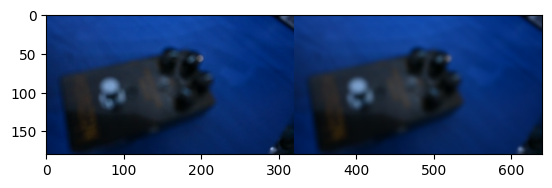

In [10]:
video_path = './focus_video.mov'
capture = cv.VideoCapture(video_path)
save_video(modify_video(capture, gaussian_blur_stack_modifier)[0], './movie-gaussian-blur.mp4')

In [11]:
def image_quality_meassure(frame):
    """
    Implementacion del algoritmo de Kanjar-Mansilamani para la cuantificacion de calidad de imagen.
    """
    f = np.fft.fft2(frame)
    af = np.abs(np.fft.fftshift(f))
    m = np.max(af)
    t_h = np.sum(af > m/1000)
    fm = t_h / frame.size
    return fm

In [12]:
def iqm_modifier(metadata, img):
    """
    Modifier que guarda, en la metadata, el resultado de aplicar `image_quality_meassure` al frame actual.
    El frame queda intacto.
    """
    metadata['iqm'] = metadata.get('iqm', [])
    metadata['iqm'].append(image_quality_meassure(img))
    return metadata, img

def iqm_roi_modifier(metadata, img):
    """
    Modifier que guarda, en la metadata, el resultado de aplicar `image_quality_meassure` a una o mas ROI's del frame actual.
    Las ROI's se obtienen de la metadata. Ver `img_roi_metadata_modifier`
    El frame queda intacto.
    """
    roi_list = metadata['roi_list']
    for idx, roi in enumerate(roi_list):
        metadata[f'iqm_roi_{idx}'] = metadata.get(f'iqm_roi_{idx}', [])
        roi_img = img[roi['h_start']:roi['h_end'], roi['w_start']:roi['w_end']]
        metadata[f'iqm_roi_{idx}'].append(image_quality_meassure(roi_img))
    return metadata, img

def img_roi_metadata_modifier(metadata, img, area=0.1, roi_count=1):
    """
    Guarda en la metadata una lista con ROI's (roi_list).
    Cada ROI contiene las coordenadas de inicio y fin en ancho y alto (h_start, h_end, w_start, w_end). 
    El frame queda intacto.
    """
    assert(roi_count%2 != 0)
    frame_width = int(capture.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv.CAP_PROP_FRAME_HEIGHT))
    frame_width_mid = frame_width // 2
    frame_height_mid = frame_height // 2
    
    roi_area = frame_width*frame_height*area
    roi_height = roi_width = int(np.sqrt(roi_area))
    
    h = roi_height//2
    w = roi_width//2
    metadata['roi_list'] = []
    for row in range(-int(roi_count/2), int(roi_count/2)+1):
        for col in range(-int(roi_count/2), int(roi_count/2)+1):
            roi = {}
            roi['h_start'] = frame_height_mid-h + row*h*2
            roi['h_end'] = frame_height_mid+h + row*h*2
            roi['w_start'] = frame_width_mid-w + col*w*2
            roi['w_end'] = frame_width_mid+w + col*w*2
            metadata['roi_list'].append(roi)
    return metadata, img

def roi_marker_modifier(metadata, img):
    roi_list = metadata['roi_list']
    image = img
    for idx, roi in enumerate(roi_list):
        start_point = (roi['w_start'], roi['h_end'])
        end_point = (roi['w_end'], roi['h_start'])
        # print(start_point)
        # print(end_point)
        color = (255, 0, 0)
        image = cv.rectangle(image, start_point, end_point, color, 2)
        image = cv.putText(image, f'{idx}', start_point, cv.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv.LINE_AA)
    return metadata, image
    
def compose(f, g):
    return lambda *args: f(*g(*args))

def max_focus_frame(focus_metrics):
    return np.argmax(focus_metrics)

def plot_focus_metric(focus_metrics, title):
    plt.plot(focus_metrics)
    plt.title(title)
    plt.xlabel('frame')
    plt.ylabel('metric')

def plot_frame(frame_idx, frames):
    # ret, frame = capture.read()
    # for i in range(frame_idx-1):
    #     ret, frame = capture.read()
    plt.imshow(frames[frame_idx])
    plt.title(f'frame {frame_idx}')
    plt.show()


A continuacion vemos el resultado de aplicar kanjar-masilamani a cada frame

Frame de maximo enfoque: 91


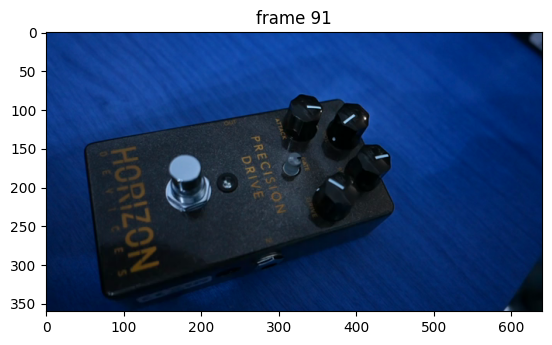

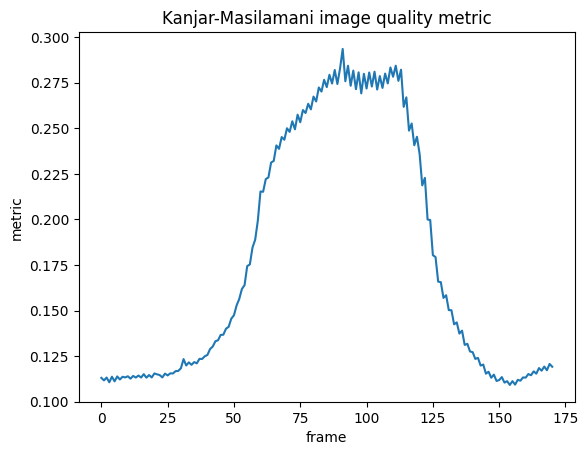

In [13]:
video_path = './focus_video.mov'
capture = cv.VideoCapture(video_path)

frames, metadata = modify_video(capture, iqm_modifier)
print(f'Frame de maximo enfoque: {max_focus_frame(metadata['iqm'])}')
plot_frame(max_focus_frame(metadata['iqm']), frames)
plot_focus_metric(metadata['iqm'], 'Kanjar-Masilamani image quality metric')

Aplicamos el algoritmo de Kanjar-Masilamani a una ROI central

Frame de maximo enfoque: 91


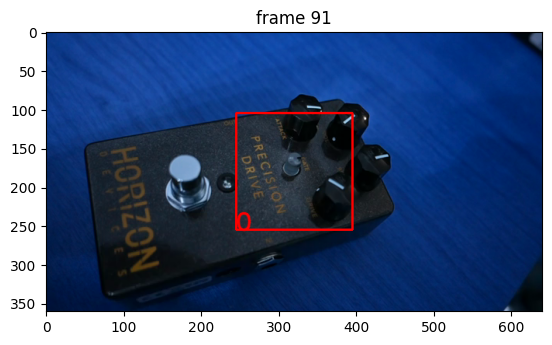

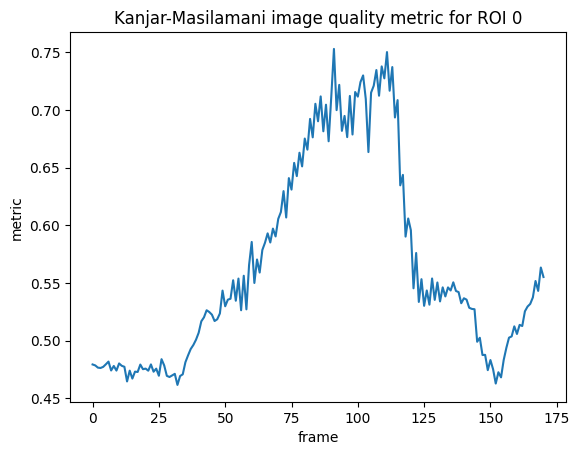

In [14]:
video_path = './focus_video.mov'
capture = cv.VideoCapture(video_path)

modifier = compose(roi_marker_modifier, compose(iqm_roi_modifier, img_roi_metadata_modifier))
frames, metadata = modify_video(capture, modifier)
print(f'Frame de maximo enfoque: {max_focus_frame(metadata['iqm_roi_0'])}')
plot_frame(max_focus_frame(metadata['iqm_roi_0']), frames)
plot_focus_metric(metadata['iqm_roi_0'], 'Kanjar-Masilamani image quality metric for ROI 0')

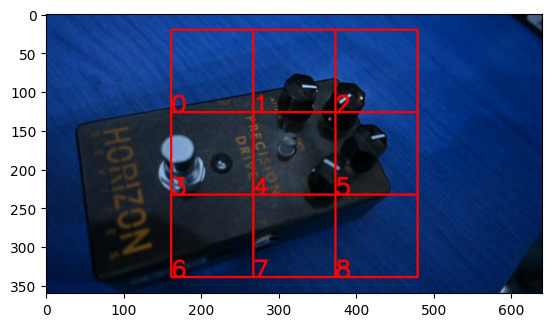

In [15]:
video_path = './focus_video.mov'
capture = cv.VideoCapture(video_path)

modifier = lambda met, frame: img_roi_metadata_modifier(met,frame, roi_count=3, area=0.05)
frames, metadata = modify_video(capture, compose(roi_marker_modifier, modifier))
plt.imshow(frames[80])

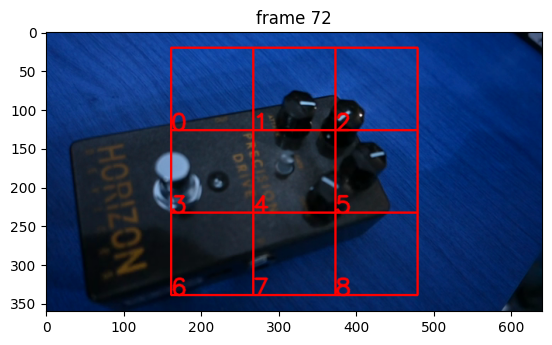

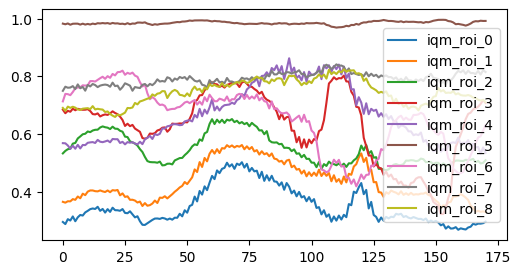

In [16]:
video_path = './focus_video.mov'
capture = cv.VideoCapture(video_path)
modifier = lambda met, frame: img_roi_metadata_modifier(met,frame, roi_count=3, area=0.05)
modifier = compose(roi_marker_modifier, compose(iqm_roi_modifier, modifier))

frames, metadata = modify_video(capture, modifier)
mean_iqm = np.mean(np.array([metadata[f'iqm_roi_{i}'] for i in range(len(metadata['roi_list']))]), axis=0)
max_frame = np.argmax(mean_iqm)
plot_frame(max_focus_frame(mean_iqm), frames)

fig, ax = plt.subplots(figsize=(6, 3))
for i in range(3*3):
    # plot_focus_metric(metadata[f'iqm_roi_{i}'], 'Kanjar-Masilamani image quality metric for ROI 0')
    ax.plot(metadata[f'iqm_roi_{i}'])
# plt.xlabel('frame')
# plt.ylabel('metric')
ax.legend([f'iqm_roi_{i}' for i in range(3*3)])

# Parte II: Implementacion de metrica basada en autovalores (Eigenvalues-based (STA2))

In [20]:
def eigenvalue_iqm(frame):
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    I = frame_gray / np.max(frame_gray)
    J = I - np.mean(I)
    S = J@J.T / ( frame_gray.shape[0] * frame_gray.shape[1] - 1)
    return np.linalg.eig(S).eigenvalues[:5].sum()

def eigenvalue_iqm_modifier(metadata, frame):    
    metadata['eig_iqm'] = metadata.get('eig_iqm', [])
    metadata['eig_iqm'].append(eigenvalue_iqm(frame))
    return metadata, frame


Frame de maximo enfoque: 77


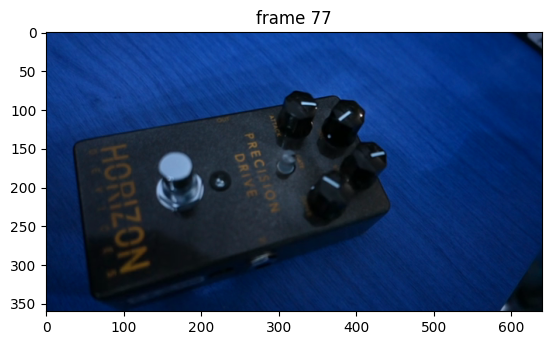

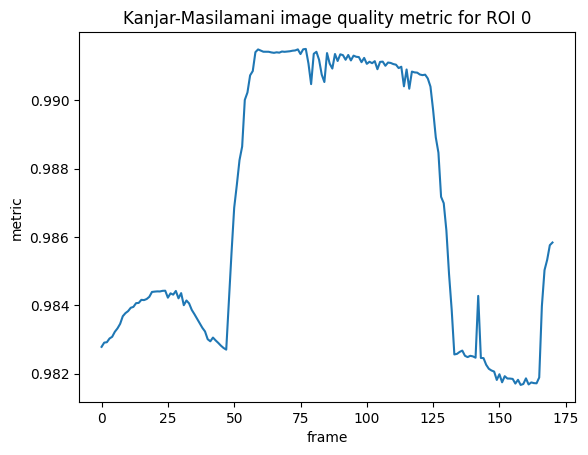

In [21]:
video_path = './focus_video.mov'
capture = cv.VideoCapture(video_path)

frames, metadata = modify_video(capture, eigenvalue_iqm_modifier)
print(f'Frame de maximo enfoque: {max_focus_frame(1 - np.array(metadata['eig_iqm'])) }')
plot_frame(max_focus_frame(1 - np.array(metadata['eig_iqm'])), frames)
plot_focus_metric(1 - np.array(metadata['eig_iqm']) , 'Kanjar-Masilamani image quality metric for ROI 0')


La metrica basada en autovalores no detecta tan bien el enfoque como el algoritmo de kanjar-masilamani

# Bonus track: Unsharp

In [22]:
def unsharp_modifier(metadata, frame, k = 2.5, ksize=(7, 7), sigmaX=5,  sigmaY=5):
    """
    Modifier aplicando el algoritmo de unsharp al frame. Modifica el frame.
    """
    blurred = cv.GaussianBlur(frame, ksize=ksize, sigmaX=sigmaX,  sigmaY=sigmaY)
    # result = frame + 5*(frame - blurred)
    result = cv.addWeighted(frame, k+1, blurred, -k, 0)
    return metadata, result

In [23]:
video_path = './focus_video.mov'
capture = cv.VideoCapture(video_path)
# save_video(modify_video(capture, unsharp_modifier)[0], './movie-unsharp.mp4')

In [24]:
video_path = './focus_video.mov'
frames, metadata = modify_video(cv.VideoCapture(video_path), iqm_modifier)
frames, metadata_unsharp = modify_video(cv.VideoCapture(video_path), compose(iqm_modifier, unsharp_modifier))

Frame de maximo enfoque: 91


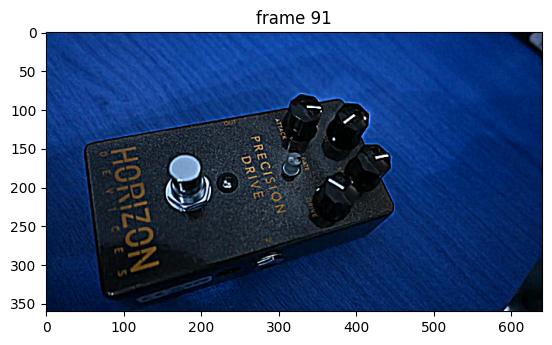

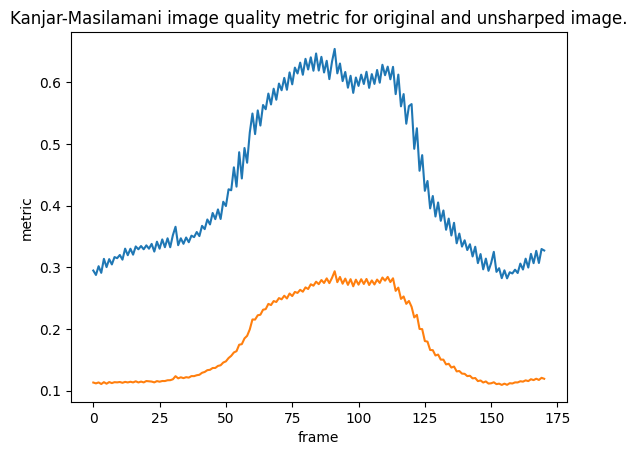

In [25]:
print(f'Frame de maximo enfoque: {max_focus_frame(metadata_unsharp['iqm'])}')
plot_frame(max_focus_frame(metadata_unsharp['iqm']), frames)
plot_focus_metric(metadata_unsharp['iqm'] , '')
plot_focus_metric(metadata['iqm'] , 'Kanjar-Masilamani image quality metric for original and unsharped image.')


In [26]:
video_path = './focus_video.mov'
frames, metadata = modify_video(cv.VideoCapture(video_path), eigenvalue_iqm_modifier)
frames, metadata_unsharp = modify_video(cv.VideoCapture(video_path), compose(eigenvalue_iqm_modifier, unsharp_modifier))


Frame de maximo enfoque: 42


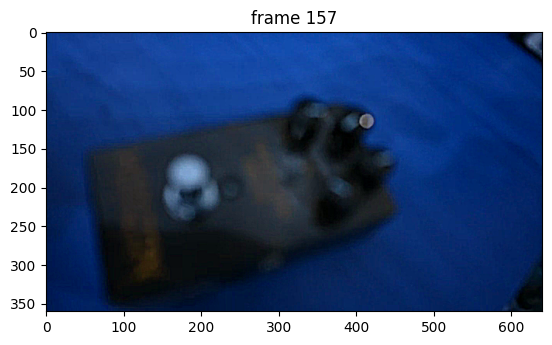

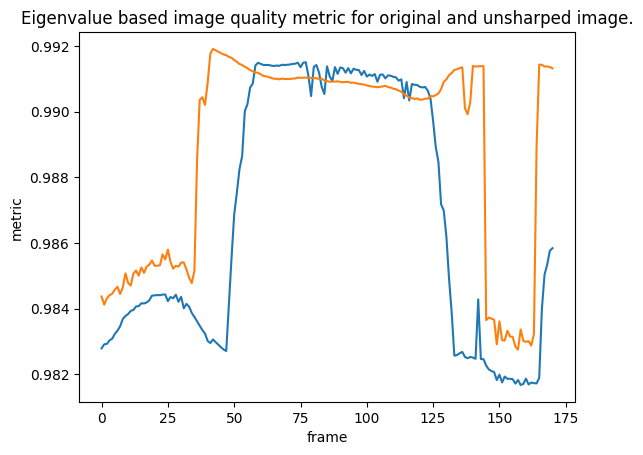

In [27]:
print(f'Frame de maximo enfoque: {max_focus_frame(1- np.array(metadata_unsharp['eig_iqm']))}')
plot_frame(max_focus_frame(metadata_unsharp['eig_iqm']), frames)
plot_focus_metric(1- np.array(metadata['eig_iqm']) , '')
plot_focus_metric(1- np.array(metadata_unsharp['eig_iqm']) , 'Eigenvalue based image quality metric for original and unsharped image.')


El frame de mejor enfoque no cambio para kanjar-masilamani pero si para el el algoritmo basado en autovalores. En este ultimo caso empeorando bastante el resultado.